<a href="https://colab.research.google.com/github/mkosaka1/capstone_project/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
ls

drive/  sample_data/


In [61]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from keras.utils import to_categorical
from glob import glob
import cv2
from sklearn.utils import shuffle




In [62]:

#let's take a look at if we're in the right folder
imagePatches = glob('/content/drive/My Drive/sorted_data/**/*.wav.jpeg', recursive=True)
for filename in imagePatches[0:15]:
    print(filename)

/content/drive/My Drive/sorted_data/happy/03-01-03-01-01-01-16.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-02-02-01-16.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-01-02-02-16.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-02-01-02-16.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-01-01-02-11.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-02-02-02-11.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-01-02-01-11.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-02-01-01-11.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-02-02-01-11.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-01-01-01-11.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-02-01-02-11.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-01-02-02-11.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-02-01-02-18.wav.jpeg
/content/drive/My Drive/sorted_data/happy/03-01-03-01-02-02-18.w

In [63]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'angry': #Folder contain Glacier Images get the '2' class label.
            label = 5
        elif labels == 'calm':
            label = 2
        elif labels == 'disgust':
            label = 7
        elif labels == 'fearful':
            label = 6
        elif labels == 'happy':
            label = 3
        elif labels == 'neutral':
            label = 1
        elif labels == 'sad':
            label = 4
        elif labels == 'surprised':
            label = 8
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=200) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {5:'angry', 2:'calm', 7:'disgust', 6:'fearful', 3:'happy', 1:'neutral',4:'sad',8:'surprised'}
    
    return labels[class_code]


In [64]:
Images, Labels = get_images('/content/drive/My Drive/sorted_data/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

In [65]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (1440, 150, 150, 3)
Shape of Labels: (1440,)


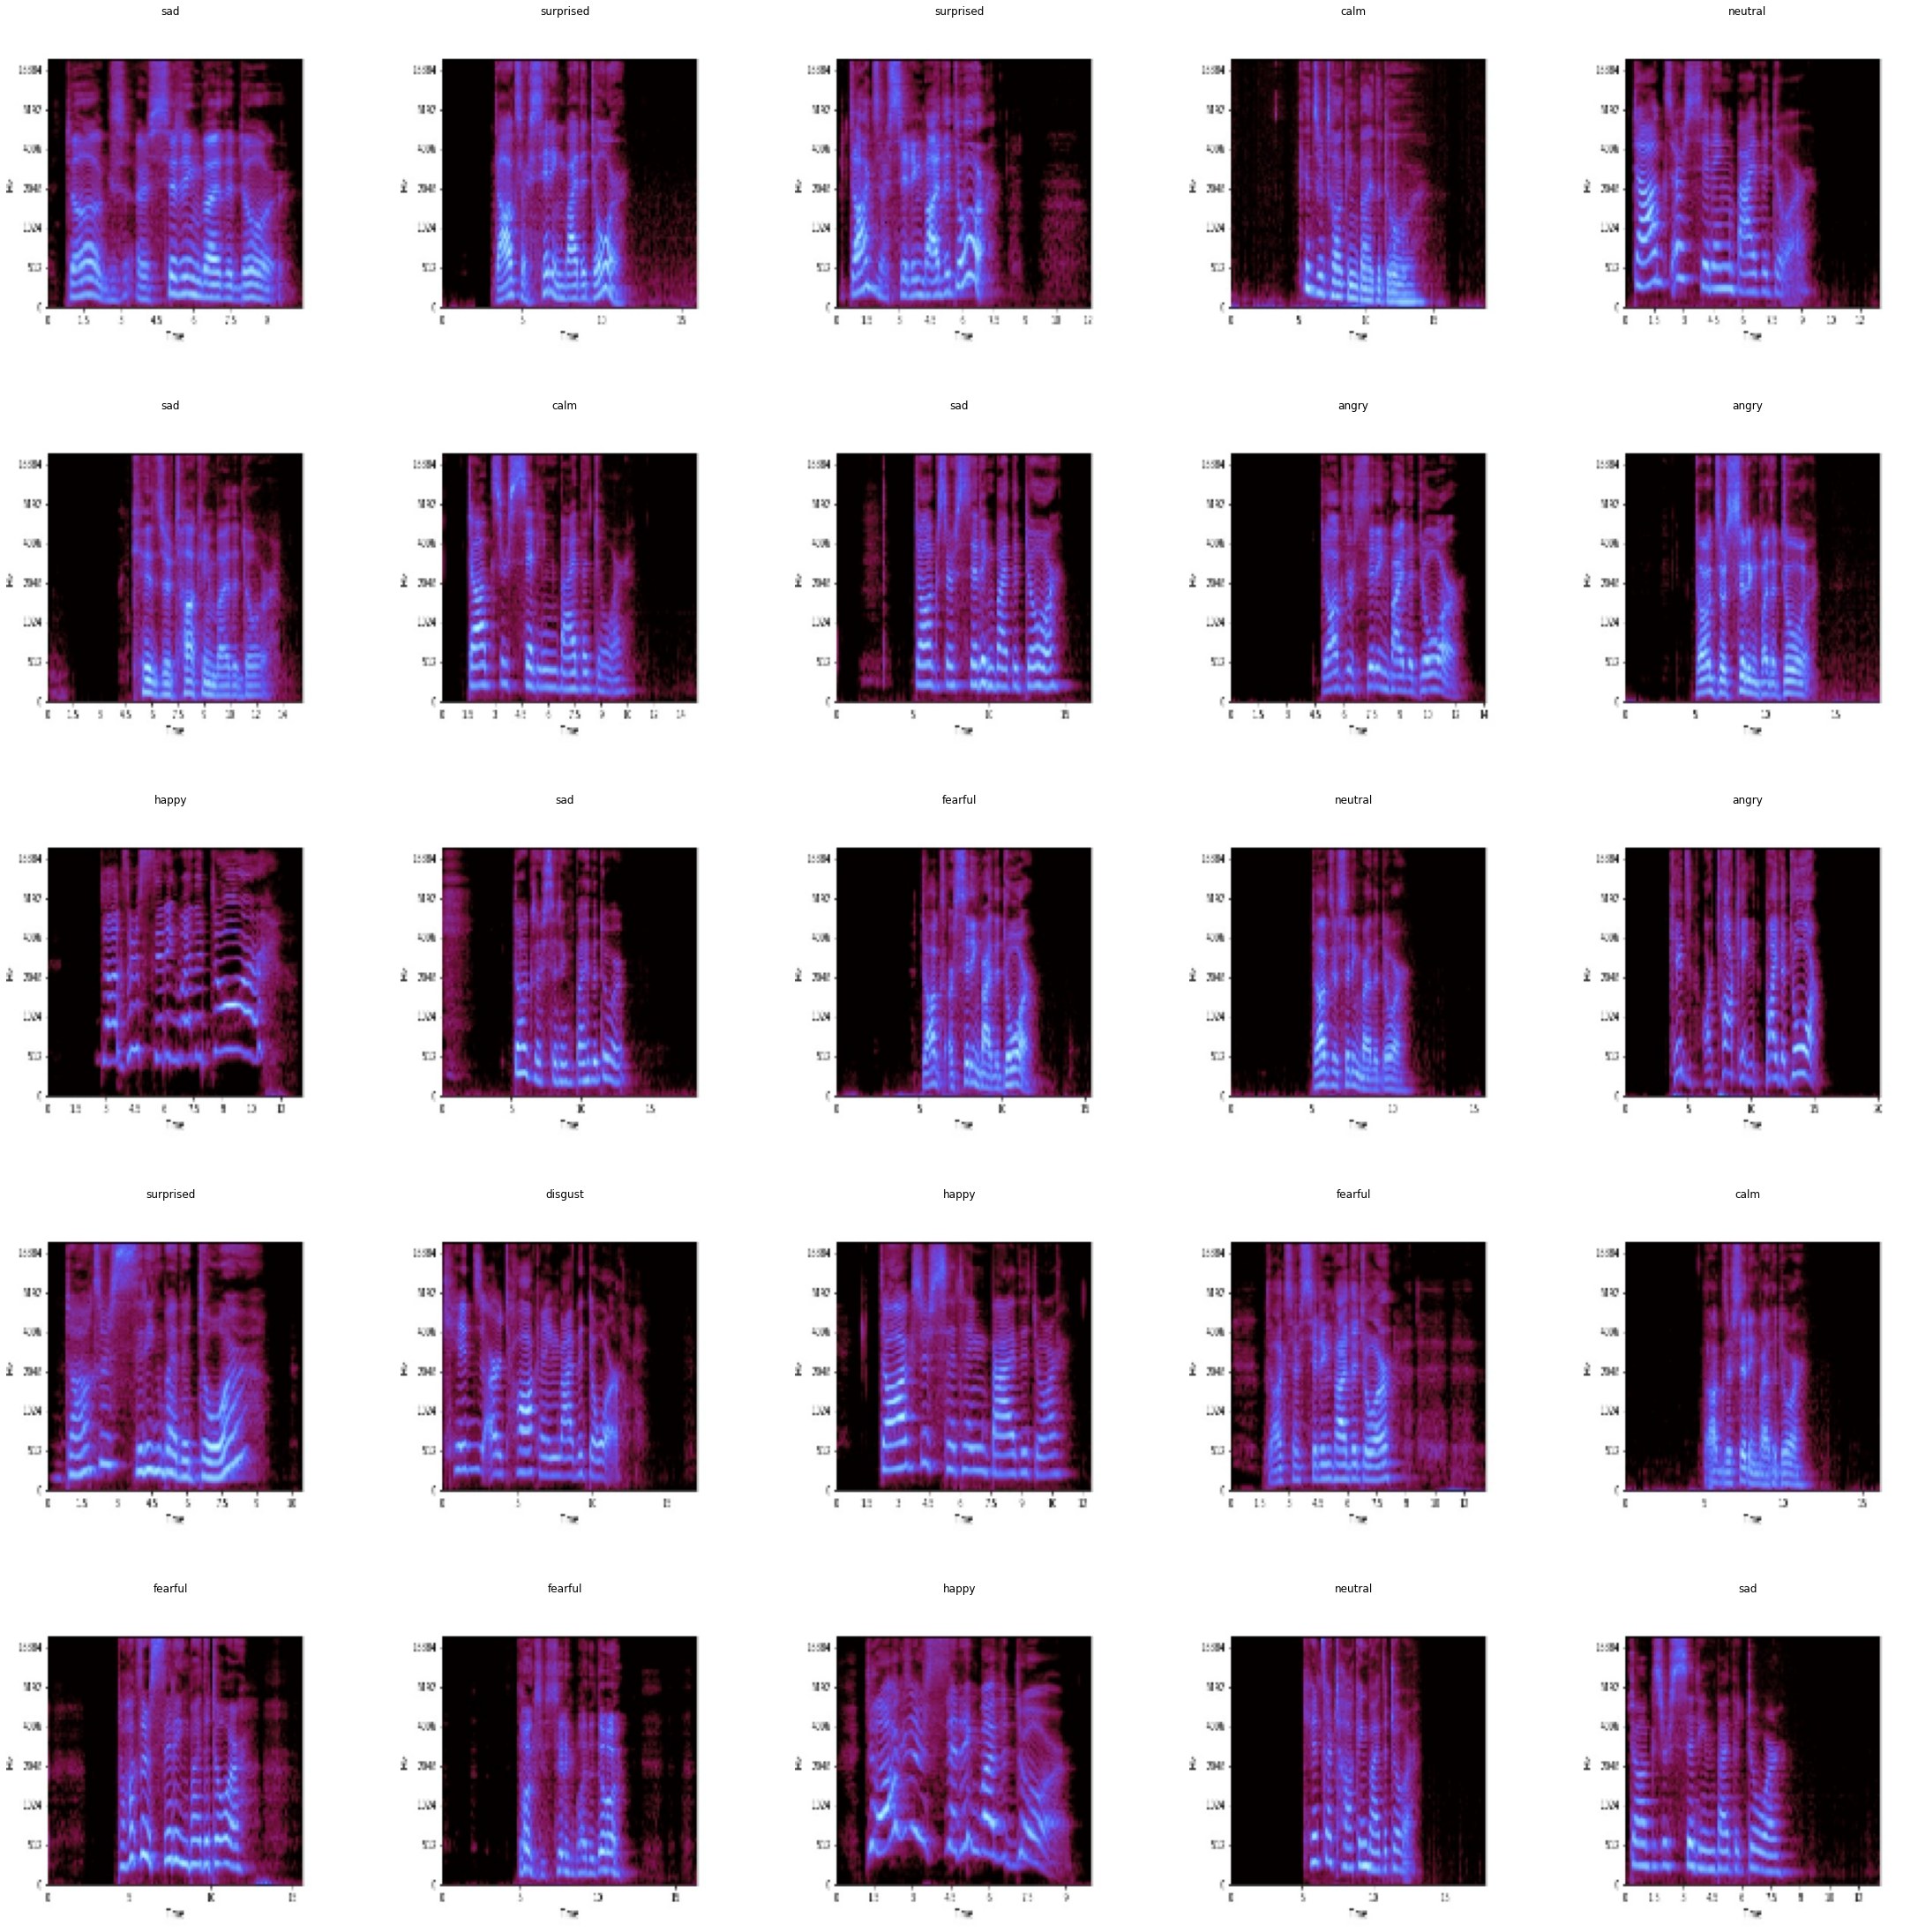

In [68]:
from random import randint

f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

In [78]:
from sklearn.model_selection import train_test_split 
 
PERC_TRAIN = 0.6 
PERC_VALIDATION = 0.1 
PERC_TEST = 0.3 
DO_VALIDATION = True 
# DO_VALIDATION = False 
 
def train_test_valid_split(all_X, all_Y): 
  left_X, valid_X, left_y, valid_y = train_test_split(all_X, all_Y, test_size=PERC_VALIDATION) 
  train_X, test_X, train_y, test_y = train_test_split(left_X, left_y, test_size=PERC_TEST / (PERC_TEST + PERC_TRAIN)) 
  return test_X, test_y, train_X, train_y, valid_X, valid_y 
 
all_X, all_Y = get_feature_data() 
 
if DO_VALIDATION: 
    test_X, test_y, train_X, train_y, valid_X, valid_y = train_test_valid_split(all_X, all_Y) 
else: 
    train_X, test_X, train_y, test_y = train_test_split(all_X, all_Y, test_size=PERC_TEST)

NameError: ignored

In [83]:
import os
import numpy as np
import shutil
import random

# # Creating Train / Val / Test folders (One time use)
root_dir = '/content/drive/My Drive/sorted_data/'
classes_dir = ['angry', 'calm', 'disgust', 'fearful','happy','neutral','sad','surprised']

val_ratio = 0.15
test_ratio = 0.05

for cls in classes_dir:
    os.makedirs(root_dir +'/train' + cls)
    os.makedirs(root_dir +'/val' + cls)
    os.makedirs(root_dir +'/test' + cls)


    # Creating partitions of the data after shuffeling
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio + test_ratio)), 
                                                               int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'/val' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test' + cls)

Total images:  192
Training:  172
Validation:  10
Testing:  10
Total images:  192
Training:  172
Validation:  10
Testing:  10
Total images:  192
Training:  172
Validation:  10
Testing:  10
Total images:  192
Training:  172
Validation:  10
Testing:  10
Total images:  192
Training:  172
Validation:  10
Testing:  10
Total images:  96
Training:  86
Validation:  5
Testing:  5
Total images:  192
Training:  172
Validation:  10
Testing:  10
Total images:  192
Training:  172
Validation:  10
Testing:  10
